# An example run of reduce-the-lead

We can run the program and see the output.

The tab completions don't work in an IPython Notebook :(

Try it in terminal if you'd like.

In [1]:
%run reducethelead.py

-------------------------------
Welcome to Reduce the Lead
-------------------------------
At what geographic level to you want to focus your testing?
A: Nationwide across States
B: Nationwide across Counties
C: Statewide across Counties
D: Countywide across Census Tracts
E: Countywide across Census Block Groups
F: Census Tractwide across Census Block Groups

Your selection: C
Which State (two letter code):NY
The ranking variable explains
0.956031 percent of the data

The most at risk regions are 
        old_houses  minority_children  u6_foreign  poverty_level  \
county                                                             
47          887029             562081       19863        2731944   
5           443970             289502       11640        2420598   
61          705512             448843       13542        1973786   
81          742957             351721       17116        1754703   
29          343897             318060        3628         752550   

        poverty_fore

Note that the ranking generated by first principal component accounts for over 95% of the variation in the dataset. This seems like a useful ranking.

We've saved a file containing risk characteristics for all counties in NY state

We can now import this saved .csv file and map the output

In [2]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import us
import urllib
import zipfile
import os
import vincent
import matplotlib.pyplot as plt

In [3]:
# loading in our dataset
df = pd.read_csv('test.csv')
df.head()

,county,old_houses,minority_children,u6_foreign,poverty_level,poverty_foreign,first_pca
0,47,887029,562081,19863,2731944,1015294,0.577116
1,5,443970,289502,11640,2420598,786926,0.533890
2,61,705512,448843,13542,1973786,726463,0.412984
3,81,742957,351721,17116,1754703,914959,0.364686
4,29,343897,318060,3628,752550,73314,0.148345


In [4]:
# we now need a shapefile of counties in NY
county_shp_url = us.states.NY.shapefile_urls()['county']
spatialfile = 'test.zip'
urllib.urlretrieve(county_shp_url, spatialfile)
zfile = zipfile.ZipFile(spatialfile)
# check if a directory exists
if not os.path.exists('shapefile'):
    os.makedirs('shapefile')
# extract the data
zfile.extractall('shapefile/')

# get file naming convention
start, filename = county_shp_url.split('/2010/')
filename = filename.split('.')[0]

# load into a dataframe
df_shp = gpd.GeoDataFrame.from_file('shapefile/'+ filename + '.shp')
# make counties ints and change column name for merging
df_shp.rename(columns = {'COUNTYFP10' : 'county'}, inplace=True)
df_shp.county = df_shp.county.astype(int)
df_shp.head()

,ALAND10,AWATER10,CBSAFP10,CLASSFP10,county,COUNTYNS10,CSAFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,LSAD10,METDIVFP10,MTFCC10,NAME10,NAMELSAD10,STATEFP10,geometry
0,1827925580,25248569,13780,H1,7,00974102,None,A,36007,+42.1619773,-075.8302910,06,None,G4020,Broome,Broome County,36,"POLYGON ((-75.532776 42.195241, -75.531387 42...."
1,838393327,172838984,42900,H1,99,00974147,464,A,36099,+42.7822943,-076.8270880,06,None,G4020,Seneca,Seneca County,36,"POLYGON ((-76.737207 42.950041, -76.7368659999..."
2,529693619,12614136,10580,H1,93,00974144,104,A,36093,+42.8175421,-074.0435834,06,None,G4020,Schenectady,Schenectady County,36,"POLYGON ((-73.899621 42.764249, -73.906785 42...."
3,1352903595,1598826734,15380,H1,63,00974130,160,A,36063,+43.4567309,-078.7921425,06,None,G4020,Niagara,Niagara County,36,"POLYGON ((-79.05427499999999 43.218436, -79.05..."
4,1689789426,33571435,10580,H1,83,00974140,104,A,36083,+42.7104206,-073.5138454,06,None,G4020,Rensselaer,Rensselaer County,36,"POLYGON ((-73.46446399999999 42.944259, -73.46..."


In [5]:
# merge dataframes
df_map = pd.merge(df, df_shp, on='county', how='outer')
df_map = gpd.GeoDataFrame(df_map)

In [12]:
# creating and saving the picture
column_you_want_to_map = 'first_pca'
map_filename = 'ny_counties.png'

plt.clf()
fig = plt.figure()
ax = df_map.plot(column=column_you_want_to_map, scheme='QUANTILES', k=9, colormap='Reds_r')
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Ranking of Childrens\' Lead Poisoning Risk, within NY Counties')
plt.savefig(map_filename, dpi=100, alpha=True)

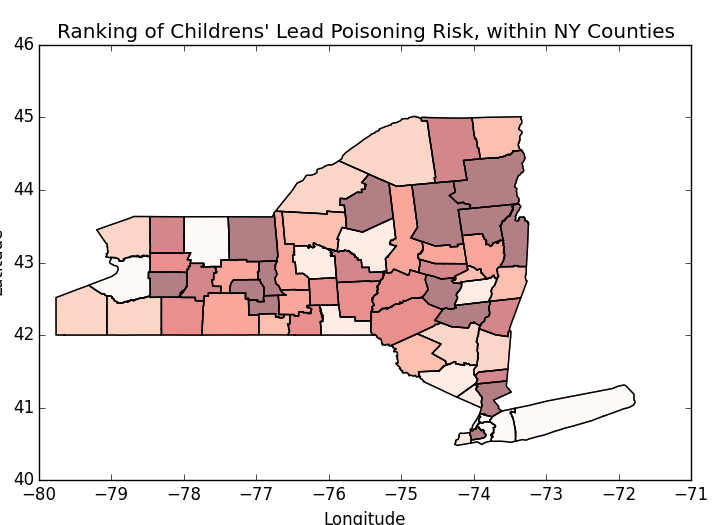

In [13]:
from IPython.display import Image
Image(filename = map_filename)

Here we can see the at risk regions in a darker shade of red. Unfortunately there is no colorbar for ranking at this stage. It turns out GeoPandas does not support a colorbar.